# Question Identification

### Problem Statement

An EdTech company has hired us as machine learning engineers to develop a model that can identify questions within transcripts of video lectures. The provided dataset contains annotated sentences categorized as questions or statements. Our task involves building a pipeline that includes text preprocessing, various text vectorization methods (TF-IDF, LSA, LDA, word embeddings, and sentence embeddings), modeling using different algorithms, evaluation using ROC curves, creating a RESTful API, and Dockerizing the solution.


### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec, Doc2Vec
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from gensim.models.doc2vec import TaggedDocument

2024-04-12 03:22:16.122328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 03:22:16.122474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 03:22:16.293302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading the dataset

In [2]:
data=pd.read_csv("/kaggle/input/dataset-news/1646977175-5e748a2d5fc288e9f69c5f86.csv")

visualizining the first 10 entries

In [3]:
data.head(10)

,Unnamed: 0,sentence,label
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence
1,1,"Born and raised in Houston, Texas, she perform...",sentence
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence
4,4,Following the disbandment of Destiny's Child i...,sentence
5,5,"Beyoncé also ventured into acting, with a Gold...",sentence
6,6,Her marriage to rapper Jay Z and portrayal of ...,sentence
7,7,Beyoncé took a hiatus from music in 2010 and t...,sentence
8,8,"Her critically acclaimed fifth studio album, B...",sentence
9,9,"A self-described ""modern-day feminist"", Beyonc...",sentence


In [4]:
data.isnull().sum().sum()

0

There is no missing values in our dataframe

Downloading necessary packages

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Cleaning the data

In [6]:
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['processed_sentence'] = data['sentence'].apply(preprocess_text)

In [7]:
data.head()

,Unnamed: 0,sentence,label,processed_sentence
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence,beyonc giselle knowlescarter bijnse beeyonsay ...
1,1,"Born and raised in Houston, Texas, she perform...",sentence,born raised houston texas performed various si...
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence,managed father mathew knowles group became one...
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence,hiatus saw release beyoncs debut album dangero...
4,4,Following the disbandment of Destiny's Child i...,sentence,following disbandment destinys child june rele...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235110 entries, 0 to 235109
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          235110 non-null  int64 
 1   sentence            235110 non-null  object
 2   label               235110 non-null  object
 3   processed_sentence  235110 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.2+ MB


#### Removing unwanted features

In [9]:
data.drop(columns=["sentence","Unnamed: 0"], inplace=True)

#### Encoding labels

In [10]:
label_map = {'question': 1, 'sentence': 0}
data['label'] = data['label'].map(label_map)

In [11]:
data.columns

Index(['label', 'processed_sentence'], dtype='object')

### Top 50 word frequency

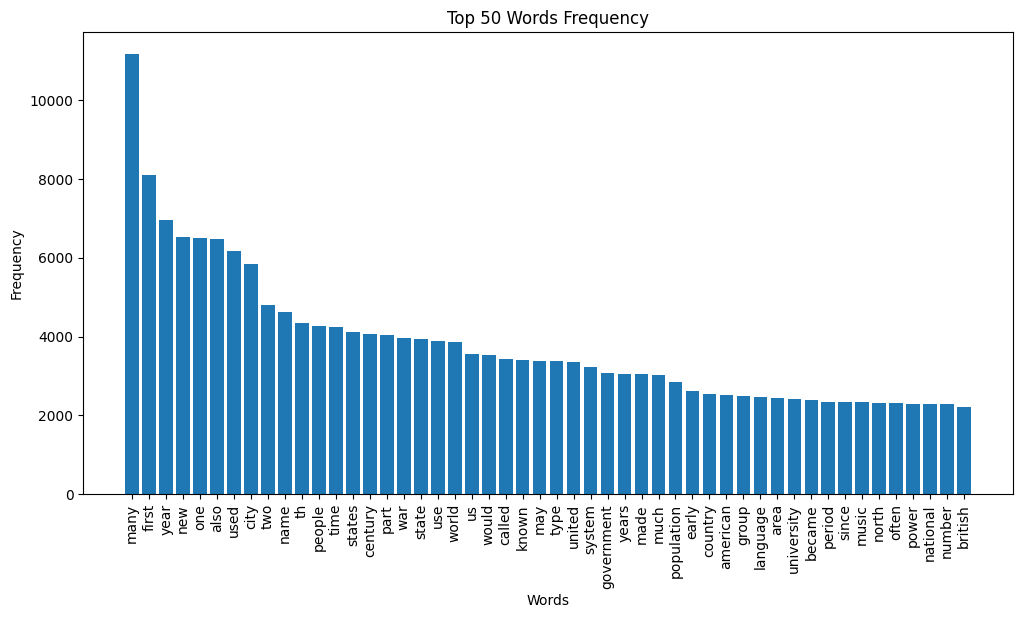

In [12]:
all_words = ' '.join(data['processed_sentence']).split()
word_freq = Counter(all_words)

top_50_words = word_freq.most_common(50)

words = [word[0] for word in top_50_words]
frequencies = [word[1] for word in top_50_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words Frequency')
plt.xticks(rotation=90)
plt.show()


In [13]:
nlp = spacy.load("en_core_web_sm")

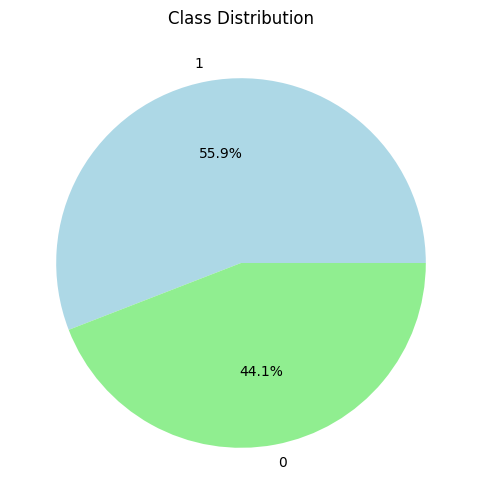

In [14]:
plt.figure(figsize=(6, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

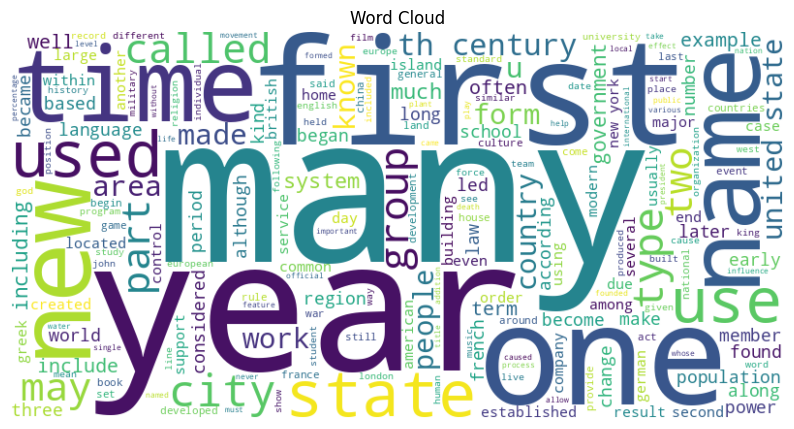

In [15]:
text = ' '.join(data['processed_sentence'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

In [16]:
data["processed_sentence"][100]

'album formally introduces beyoncs alter ego sasha fierce conceived making single crazy love selling copies first week debuting atop billboard giving beyonc third consecutive numberone album us'

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235110 entries, 0 to 235109
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   label               235110 non-null  int64 
 1   processed_sentence  235110 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [18]:
data.head()

,label,processed_sentence
0,0,beyonc giselle knowlescarter bijnse beeyonsay ...
1,0,born raised houston texas performed various si...
2,0,managed father mathew knowles group became one...
3,0,hiatus saw release beyoncs debut album dangero...
4,0,following disbandment destinys child june rele...


# Models

# Text Vectorization: TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a popular technique for converting text documents into numerical vectors. It calculates the importance of a word in a document relative to a collection of documents.

## Modeling with TF-IDF

I will apply the following classification models:

1. **Logistic Regression**
2. **Naive Bayes**
3. **Random Forest**
4. **Neural Network (NN)**
5. **Decision Tree**

Each model will be trained and evaluated using TF-IDF vectors as features.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_sentence'], data['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [20]:
X_train_tfidf.shape,X_test_tfidf.shape,y_train.shape,y_test.shape

((188088, 86436), (47022, 86436), (188088,), (47022,))


Since the data is high dimensional, directly applying a neural network method may not be the best approach due to potential overfitting and computational complexity. However, we can explore the following two approaches:

We can apply PCA to reduce the dimensionality of the data. Then, we can build a model using the reduced-dimensional data.

Despite the high dimensionality of the data, we will still experiment by directly applying a neural network to the data without dimensionality reduction. This approach will help us understand the performance and limitations of neural networks on high-dimensional data.


In [21]:
# Model Training
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_tfidf, y_train)

predictions_lr = logistic_regression.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, predictions_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.8194249500233933


In [22]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)

predictions_nb = naive_bayes.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, predictions_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

Naive Bayes Accuracy: 0.7507974990430012


In [23]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=-1)

random_forest.fit(X_train_tfidf, y_train)
predictions_rf = random_forest.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8042831015269448


In [24]:
decision_tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)

decision_tree.fit(X_train_tfidf, y_train)
predictions_dt = decision_tree.predict(X_test_tfidf)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.7747862702564757


In [25]:
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train_tfidf, y_train, epochs=10, batch_size=128, validation_data=(X_test_tfidf, y_test))

loss, accuracy_nn = model_nn.evaluate(X_test_tfidf, y_test)
print("Neural Network Accuracy:", accuracy_nn)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.7425 - loss: 0.5044 - val_accuracy: 0.8323 - val_loss: 0.3805
Epoch 2/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.8785 - loss: 0.2880 - val_accuracy: 0.8441 - val_loss: 0.3691
Epoch 3/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9222 - loss: 0.1923 - val_accuracy: 0.8436 - val_loss: 0.4040
Epoch 4/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9561 - loss: 0.1167 - val_accuracy: 0.8452 - val_loss: 0.4887
Epoch 5/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9796 - loss: 0.0599 - val_accuracy: 0.8399 - val_loss: 0.6192
Epoch 6/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9910 - loss: 0.0297 - val_accuracy: 0.8360 - val_loss: 0.7396
Epoch 7/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.8318 - val_loss: 0.8879
Epoch 8/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9966 -

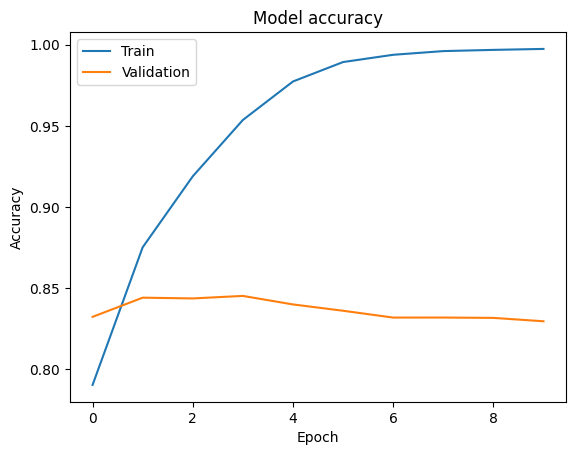

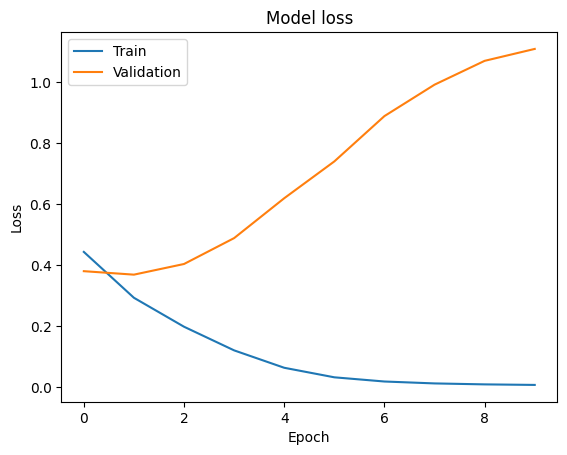

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



It's interesting to see that even though the neural network model performs poorly on high-dimensional data, it still manages to make some accurate predictions. This highlights the robustness and flexibility of neural networks in handling complex data, albeit with potential challenges such as overfitting and computational complexity.

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


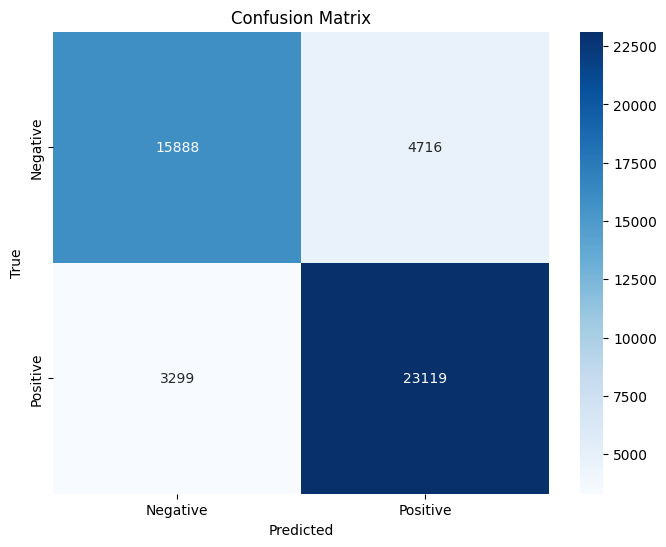

In [27]:
y_pred_prob = model_nn.predict(X_test_tfidf)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



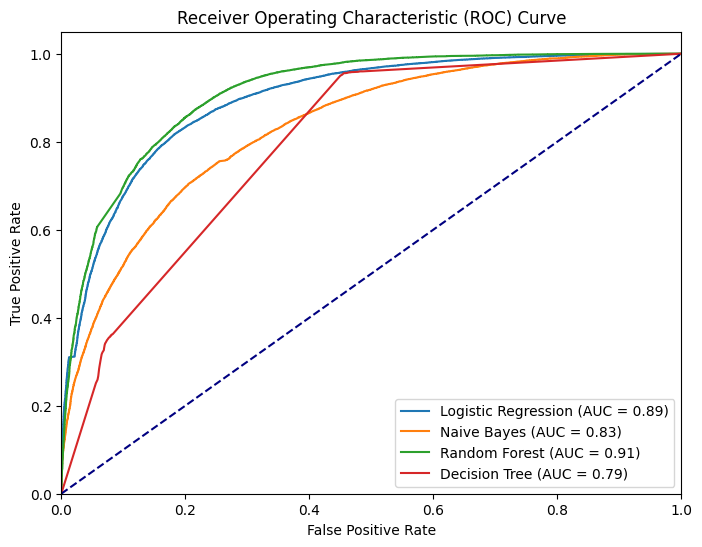

In [28]:
classifiers = {
    "Logistic Regression": logistic_regression,
    "Naive Bayes": naive_bayes,
    "Random Forest": random_forest,
    "Decision Tree": decision_tree
}

plt.figure(figsize=(8, 6))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        probas = clf.predict_proba(X_test_tfidf)[:, 1]
    else:
        probas = clf.decision_function(X_test_tfidf)
        
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Enhanced Model Performance

After experimenting with various models on the dataset, we have observed that certain models are performing better than others. Actually I adjusted the depths of trees and also the number of trees, I can make a better accuracy by adjusting those parameters. But that might take a lot of time and computational powers.

# Word Embedding

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235110 entries, 0 to 235109
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   label               235110 non-null  int64 
 1   processed_sentence  235110 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


### Word2Vec

In [30]:
data.head()

,label,processed_sentence
0,0,beyonc giselle knowlescarter bijnse beeyonsay ...
1,0,born raised houston texas performed various si...
2,0,managed father mathew knowles group became one...
3,0,hiatus saw release beyoncs debut album dangero...
4,0,following disbandment destinys child june rele...


# Word2Vec

We're utilizing Word2Vec to generate sentence embeddings from processed sentences in our dataset. The embeddings are then used for training and testing our models.

In [31]:
sentences = [word_tokenize(sentence) for sentence in data['processed_sentence']]
word2vec_model = Word2Vec(sentences, min_count=1) 

def sentence_to_vec_word2vec(sentence, model):
    vector_size = model.vector_size
    words = sentence.split()
    sentence_vec = []
    for word in words:
        if word in model.wv:
            sentence_vec.append(model.wv[word])
    if sentence_vec:
        return np.mean(sentence_vec, axis=0)
    else:
        return np.zeros(vector_size) 

X_word2vec = []
y_encoded = []
for sentence, label in zip(data['processed_sentence'], data['label']):
    vec = sentence_to_vec_word2vec(sentence, word2vec_model)
    X_word2vec.append(vec)
    y_encoded.append(label)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_encoded)

X_word2vec = np.array(X_word2vec)
y_encoded = np.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y_encoded, test_size=0.2, random_state=42)

In [32]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((188088, 100), (47022, 100), (188088,), (47022,))

With just 100 features from Word2Vec, we have a compact space to work with. So, we can either craft a more effective neural network or opt for the elegance of an LSTM to capture sequence nuances. It's a sweet spot for enhancing model performance!

In [33]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy:", accuracy_logistic)

Logistic Regression Accuracy: 0.6429330951469525


In [34]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=-1)

random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7834843264854748


In [35]:
decision_tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)

decision_tree.fit(X_train, y_train)
predictions_dt = decision_tree.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.6717281272595806


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6871 - loss: 0.5748 - val_accuracy: 0.7482 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 2/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7557 - loss: 0.4983 - val_accuracy: 0.7635 - val_loss: 0.4843 - learning_rate: 0.0010
Epoch 3/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7703 - loss: 0.4753 - val_accuracy: 0.7726 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 4/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7783 - loss: 0.4646 - val_accuracy: 0.7804 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 5/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7836 - loss: 0.4568 - val_accuracy: 0.7807 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 6/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7872 - loss: 0.4497 - val_accuracy: 0.7796 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 7/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7880 - l

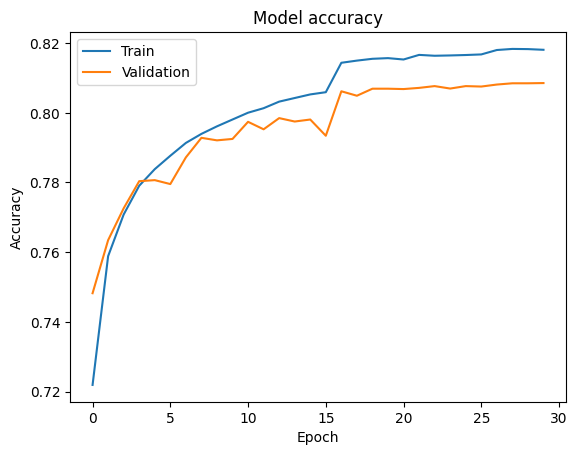

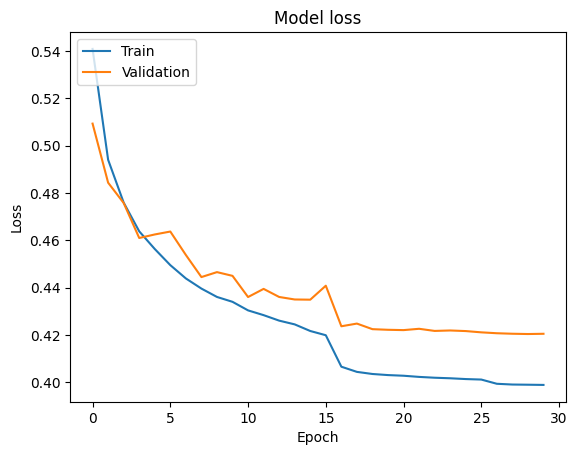

In [36]:
lr = 0.001
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=[rd_lr])

y_pred_prob = model_nn.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_nn.evaluate(X_test, y_test)
print("Validation Loss:", loss)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


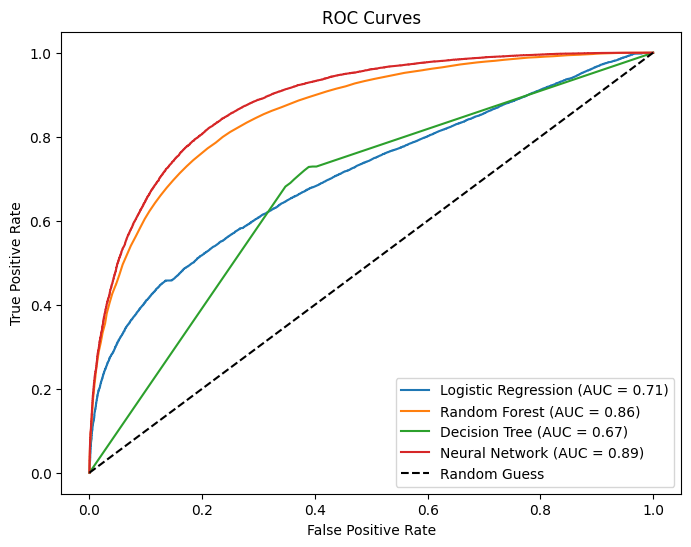

In [37]:
# Logistic Regression
y_pred_logistic_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic_prob)
auc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

# Random Forest
y_pred_rf_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

# Decision Tree
y_pred_dt_prob = decision_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
auc_dt = roc_auc_score(y_test, y_pred_dt_prob)

# Neural Network
y_pred_nn_prob = model_nn.predict(X_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()



Looks like we're onto something! This model is shining brighter than the rest, boasting an impressive accuracy and loss reduction. Plus, with an AUC score, it's really outdoing itself. Validation loss looks solid too. It's a clear winner among the models we've tried!

# Sentence Embedding

We're using Doc2Vec to generate sentence embeddings from the processed sentences in our dataset. 
Here's a summary:

We split the dataset into training and testing sets.
Each sentence is tokenized and tagged with its index.
We then train a Doc2Vec model on the training set.
Finally, we compute the sentence embeddings for both the training and testing sets using the trained model.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_sentence'], data['label'], test_size=0.2, random_state=42)

train_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]
test_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_test)]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(train_tagged)
model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)

def compute_sentence_embedding(sentence):
    return model.infer_vector(word_tokenize(sentence.lower()))

X_train_embeddings = np.array([compute_sentence_embedding(sentence) for sentence in X_train])
X_test_embeddings = np.array([compute_sentence_embedding(sentence) for sentence in X_test])

In [39]:
X_train,X_test=X_train_embeddings,X_test_embeddings
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188088, 100), (47022, 100), (188088,), (47022,))

The same goes here tooooo!!!!
I really like nn

In [40]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy:", accuracy_logistic)

Logistic Regression Accuracy: 0.6620305388966866


In [41]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=-1)

random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8268470077835907


In [42]:
decision_tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)

decision_tree.fit(X_train, y_train)
predictions_dt = decision_tree.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.7133044107013738


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7697 - loss: 0.4903 - val_accuracy: 0.8189 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 2/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8355 - loss: 0.3830 - val_accuracy: 0.8217 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 3/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8405 - loss: 0.3761 - val_accuracy: 0.8271 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 4/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8473 - loss: 0.3664 - val_accuracy: 0.8324 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 5/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8493 - loss: 0.3632 - val_accuracy: 0.8326 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 6/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8493 - loss: 0.3607 - val_accuracy: 0.8331 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 7/20
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8506 - loss: 0.3576

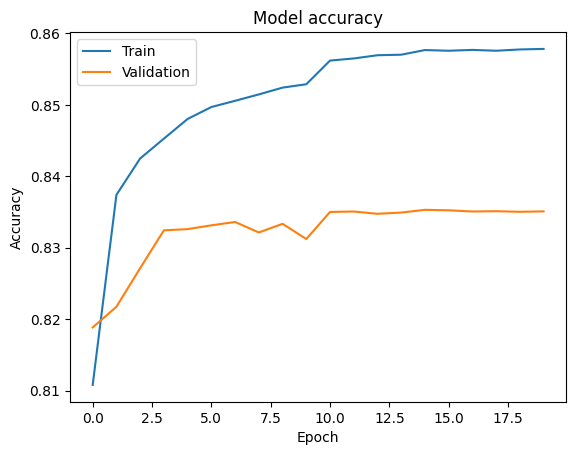

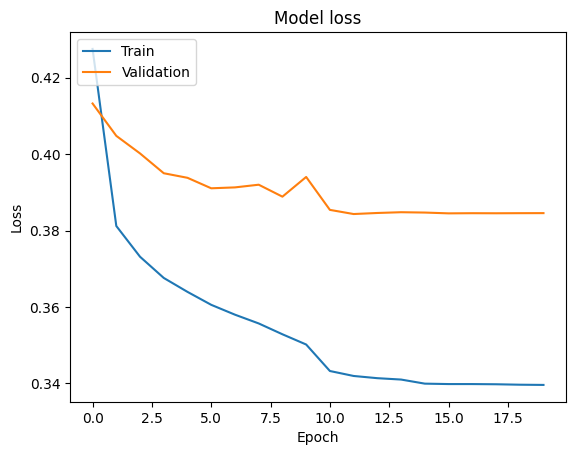

In [43]:
lr = 0.001
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), callbacks=[rd_lr])

y_pred_prob = model_nn.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_nn.evaluate(X_test, y_test)
print("Validation Loss:", loss)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


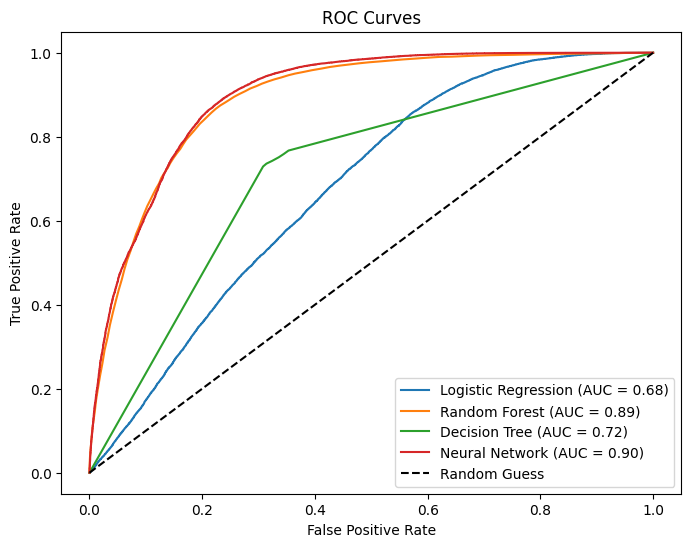

In [44]:
y_pred_logistic_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic_prob)
auc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

# Random Forest
y_pred_rf_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

# Decision Tree
y_pred_dt_prob = decision_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
auc_dt = roc_auc_score(y_test, y_pred_dt_prob)

# Neural Network
y_pred_nn_prob = model_nn.predict(X_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

Same goes here tooooo!
NN>>>> Everything

# LSA+TFIDF

We're using TF-IDF vectorization followed by Latent Semantic Analysis (LSA) to reduce the dimensionality of the feature space.

Plan:

We'll initialize TF-IDF vectorization to convert the text data into numerical vectors.
Then, we'll apply LSA to further reduce the dimensionality of the TF-IDF vectors to 100 components.
Finally, we'll split the dataset into training and testing sets for model training and evaluation.

In [45]:
data.head()

,label,processed_sentence
0,0,beyonc giselle knowlescarter bijnse beeyonsay ...
1,0,born raised houston texas performed various si...
2,0,managed father mathew knowles group became one...
3,0,hiatus saw release beyoncs debut album dangero...
4,0,following disbandment destinys child june rele...


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235110 entries, 0 to 235109
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   label               235110 non-null  int64 
 1   processed_sentence  235110 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [47]:
X = data['processed_sentence']
y = data['label']

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

lsa_model = TruncatedSVD(n_components=100)  
X_lsa = lsa_model.fit_transform(X_tfidf)
X_train, X_test, y_train, y_test = train_test_split(X_lsa, y, test_size=0.2, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188088, 100), (47022, 100), (188088,), (47022,))

In [49]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy:", accuracy_logistic)

Logistic Regression Accuracy: 0.6849985113351197


In [50]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=-1)

random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8305686699842627


In [51]:
decision_tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)

decision_tree.fit(X_train, y_train)
predictions_dt = decision_tree.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.7359533835226064


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6774 - loss: 0.5832 - val_accuracy: 0.7706 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 2/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7732 - loss: 0.4733 - val_accuracy: 0.7791 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 3/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7840 - loss: 0.4571 - val_accuracy: 0.7824 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 4/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7889 - loss: 0.4482 - val_accuracy: 0.7866 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 5/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7927 - loss: 0.4419 - val_accuracy: 0.7914 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 6/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7954 - loss: 0.4366 - val_accuracy: 0.7904 - val_loss: 0.4450 - learning_rate: 0.0010
Epoch 7/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7976 - l

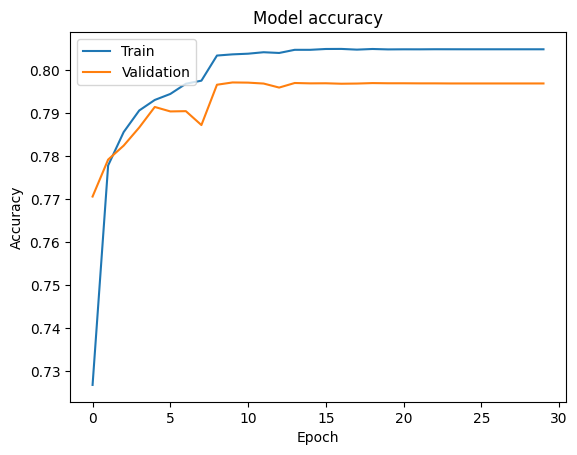

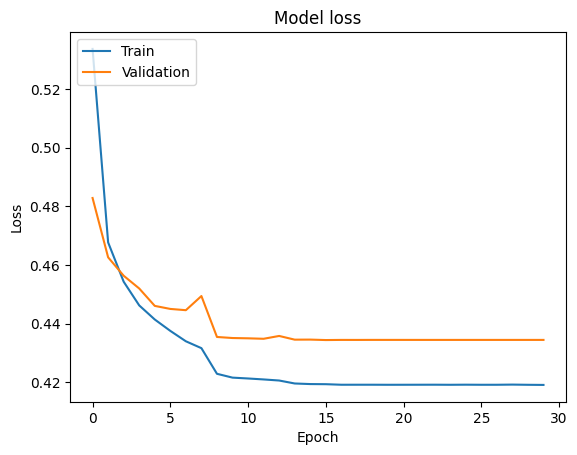

In [52]:
lr = 0.001
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=[rd_lr])

y_pred_prob = model_nn.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_nn.evaluate(X_test, y_test)
print("Validation Loss:", loss)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


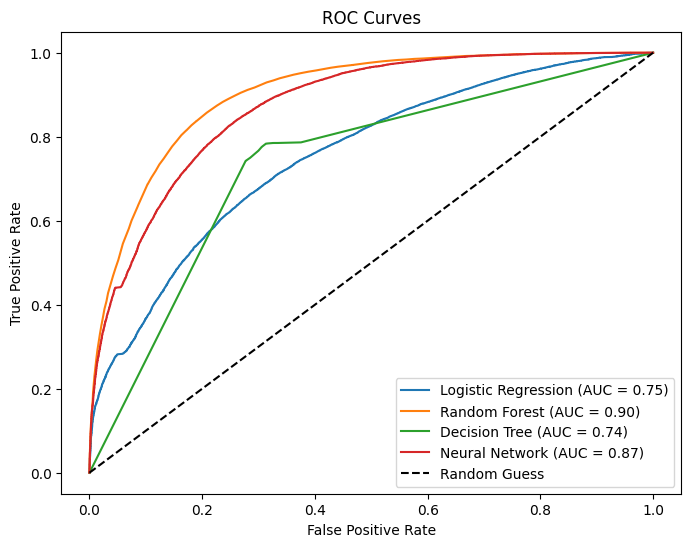

In [53]:
y_pred_logistic_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic_prob)
auc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

# Random Forest
y_pred_rf_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

# Decision Tree
y_pred_dt_prob = decision_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
auc_dt = roc_auc_score(y_test, y_pred_dt_prob)

# Neural Network
y_pred_nn_prob = model_nn.predict(X_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# LDA+Bag-of-words

We're using Latent Dirichlet Allocation (LDA) to create topic distributions from the text data. After transforming the data using CountVectorizer, we split it into training and testing sets for model evaluation.

In [54]:
X = data['processed_sentence']
y = data['label']

# Vectorization using CountVectorizer
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

In [55]:
lda_model = LatentDirichletAllocation(n_components=11, max_iter=5,
                                random_state = 42)
X_lda = lda_model.fit_transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188088, 11), (47022, 11), (188088,), (47022,))

In [57]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy:", accuracy_logistic)

Logistic Regression Accuracy: 0.5663519203776956


In [58]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=-1)

random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8516864446429331


In [59]:
decision_tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)

decision_tree.fit(X_train, y_train)
predictions_dt = decision_tree.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.7896303857768704


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5816 - loss: 0.6675 - val_accuracy: 0.7631 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 2/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7898 - loss: 0.4727 - val_accuracy: 0.8253 - val_loss: 0.4103 - learning_rate: 0.0010
Epoch 3/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8303 - loss: 0.4018 - val_accuracy: 0.8336 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 4/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8378 - loss: 0.3854 - val_accuracy: 0.8423 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 5/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8443 - loss: 0.3718 - val_accuracy: 0.8417 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 6/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8434 - loss: 0.3722 - val_accuracy: 0.8458 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 7/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8443 - loss: 0.3696

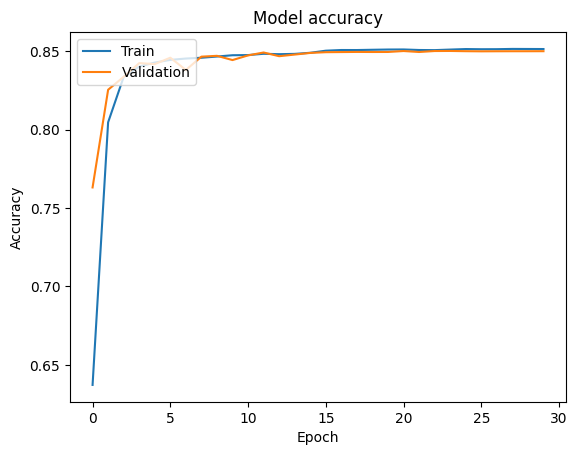

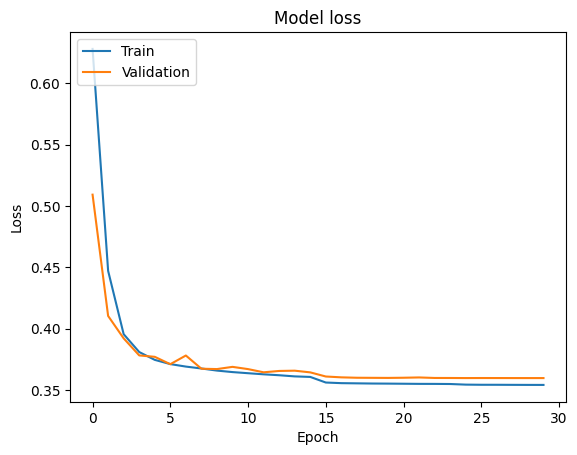

In [60]:
lr = 0.001
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=[rd_lr])

y_pred_prob = model_nn.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_nn.evaluate(X_test, y_test)
print("Validation Loss:", loss)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


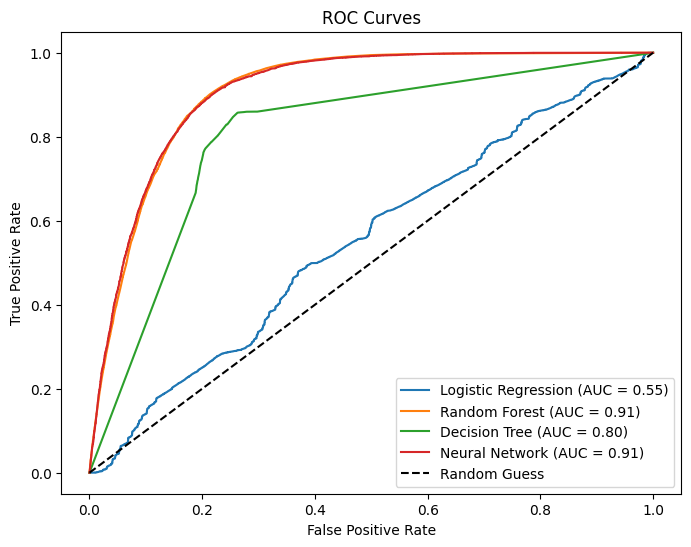

In [61]:
# Logistic Regression
y_pred_logistic_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic_prob)
auc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

# Random Forest
y_pred_rf_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

# Decision Tree
y_pred_dt_prob = decision_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
auc_dt = roc_auc_score(y_test, y_pred_dt_prob)

# Neural Network
y_pred_nn_prob = model_nn.predict(X_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()